In [1]:
from scipy.integrate import quad, trapz, fixed_quad
import theano
import theano.tensor as T
from theano.tests.unittest_tools import verify_grad
from theano.compile.ops import as_op

import numpy as np
import pymc3 as pm

import matplotlib.pyplot as plt

import astropy.units as u

from tqdm import tqdm

from gammapy.spectrum import CountsPredictor, CountsSpectrum

from utils import load_spectrum_observations, plot_spectra, Log10Parabola, integrate_spectrum, wstat_profile
from forward_fold_model import model_probability, ln_profile_likelihood

%matplotlib inline

In [2]:
theano.config.floatX ='float32'
# print(theano.config)
class Integrate(theano.Op):
    def __init__(self, expr, var, lower, upper, *inputs):
        super().__init__()
        self._expr = expr
        self._var = var
        self._extra_vars = inputs
        self.lower = lower
        self.upper = upper
        self._func = theano.function(
            [var] + list(self._extra_vars),
            self._expr,
            on_unused_input='ignore'
        )
    
    def make_node(self, *inputs):
        assert len(self._extra_vars)  == len(inputs)
        return theano.Apply(self, list(inputs), [T.dscalar().type()])
    
    def perform(self, node, inputs, out):
        x = np.linspace(self.lower, self.upper, num=3)
        y = np.array([self._func(i , *inputs) for i in x])
        val = trapz(y, x)
#         print(val)
#         val = quad(self._func, self.lower, self.upper, args=tuple(inputs))[0]
        out[0][0] = np.array(val)
        
    def grad(self, inputs, grads):
        out, = grads
        grads = T.grad(self._expr, self._extra_vars)
        dargs = []
        for grad in grads:
            integrate = Integrate(grad, self._var, self.lower, self.upper, *self._extra_vars)
            darg = out * integrate(*inputs)
            dargs.append(darg)
            
        return dargs

In [3]:
def apply_range(*arr, fit_range, bins):
    idx = np.searchsorted(bins.to(u.TeV).value, fit_range.to(u.TeV).value )
    return [a[idx[0]:idx[1]] for a in arr]

def forward_fold_gammapy(amplitude, alpha, beta, observation):
#     bins = obs.on_vector.energy.bins
    model = Log10Parabola(
        amplitude=amplitude * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
        reference=1 * u.Unit('TeV'),
        alpha=alpha * u.Unit(''),
        beta=beta * u.Unit(''),
    )
    
    predictor = CountsPredictor(model=model, aeff=observation.aeff, edisp=observation.edisp, livetime=observation.livetime)
    predictor.run()
    counts = predictor.npred.data.data
#     counts *= observation.on_vector.areascal
    return counts.value

In [4]:
def forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observation, fit_range=None):

    obs_bins = observation.on_vector.energy.bins.to_value(u.TeV)

    
    aeff_bins = observation.aeff.energy
    e_reco_bins = observation.edisp.e_reco
    e_true_bins = observation.edisp.e_true
     
#     lo = obs_bins.min()
#     hi = obs_bins.max()
#     print(hi, lo)
#     if fit_range:
#         lo = max(fit_range[0].to_value(u.TeV), lo)
#         hi = min(fit_range[1].to_value(u.TeV), hi )
#     print(hi, lo)
#     e_mask = (obs_bins >= lo ) & (obs_bins <= hi)
#     print(e_mask, obs_bins)
#     aeff_mask = (aeff_bins.lo.to_value(u.TeV) > lo ) & (aeff_bins.hi.to_value(u.TeV) <= hi)
#     e_reco_mask = (e_reco_bins.lo.to_value(u.TeV) > lo ) & (e_reco_bins.hi.to_value(u.TeV) <= hi)
#     e_true_mask = (e_true_bins.lo.to_value(u.TeV) > lo ) & (e_true_bins.hi.to_value(u.TeV) <= hi)
    
   
    lower =  e_true_bins.lo.to_value(u.TeV)
    upper = e_true_bins.hi.to_value(u.TeV)

    amplitude *= 1e-11
    
    energy = T.dscalar('energy')
    amplitude_ = T.dscalar('amplitude_')
    alpha_ = T.dscalar('alpha_')
    beta_ = T.dscalar('beta_')

    func = amplitude_ * energy **(-alpha_ - beta_ * T.log10(energy))
    
    counts = []
    for a, b in zip(lower, upper):
        c = Integrate(func, energy, a, b, amplitude_, alpha_, beta_)(amplitude, alpha, beta)
        counts.append(c)

    counts = T.stack(counts)
    aeff = observation.aeff.data.data.to_value(u.cm**2).astype(np.float32)
    aeff = T.constant(aeff)
    

    counts *= aeff
    counts *= theano.shared(observation.livetime.to_value(u.s))
    edisp = observation.edisp.pdf_matrix
    edisp = T.constant(edisp)
    
    if fit_range:
        idx = np.searchsorted(obs_bins, fit_range.to_value(u.TeV))
        return T.dot(counts, edisp)[idx[0]:idx[1]]

    return T.dot(counts, edisp)

In [7]:
obs_list, fit_range = load_spectrum_observations('fact')
observation = obs_list[0]
energy_bins = observation.on_vector.energy.bins

observation, fit_range,# [obs.alpha for obs in observations]

(<gammapy.spectrum.observation.SpectrumObservation at 0x7f5478142160>,
 <Quantity [ 0.4, 30. ] TeV>)

In [8]:
def wstat_model(amplitude, alpha, beta, observation, fit_range):
    mu_sig = forward_fold_gammapy(amplitude, alpha, beta, observation=observation)
    on_data = observation.on_vector.data.data.value
    off_data = observation.off_vector.data.data.value
    
    mu_sig, on_data, off_data, obs_alpha = apply_range(mu_sig, on_data, off_data, observation.alpha, fit_range=fit_range, bins=energy_bins)
    p = ln_profile_likelihood(mu_sig, on_data, off_data, alpha=obs_alpha)
    p = -0.5*sum(p)
    return p, mu_sig

wstat_model(4, 2, 0.5, observation, fit_range=fit_range)

(6011.934915181168,
 array([ 2.83641875,  5.03451983,  8.58513145, 13.73386645, 20.43515058,
        27.81452573, 34.29191945, 39.77983177, 43.17620902, 43.75214362,
        43.23565957, 40.99682698, 36.98690407, 33.15867575, 29.14912131,
        24.9871197 , 21.71731737, 18.67498731, 15.63194352, 13.21337521,
        11.05064186,  9.0374708 ,  7.52087301,  6.18769006,  4.93665392,
         3.97537069,  3.13799023,  2.4017132 ,  1.86052837,  1.42260807,
         1.05535167,  0.78090854,  0.54856758,  0.35638484]))

In [9]:
def wstat_model_symbolic(mu_sig, observation, fit_range):
    on_data = observation.on_vector.data.data.value
    off_data = observation.off_vector.data.data.value
    
    mu_sig, on_data, off_data, obs_alpha = apply_range(mu_sig, on_data, off_data, observation.alpha, fit_range=fit_range, bins=energy_bins)
    p = ln_profile_likelihood(mu_sig, on_data, off_data, alpha=obs_alpha)
    p = -0.5*sum(p)
    return p, mu_sig

In [12]:
amplitude = T.dscalar('amplitude')
alpha = T.dscalar('alpha')
beta = T.dscalar('beta')
cf = forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observation, fit_range=fit_range)
counts_symbolic = cf.eval({amplitude: 4.0, alpha: 2.0, beta: 0.5})

_, counts_gammapy = wstat_model(4, 2, 0.5, observation, fit_range=fit_range)

_, counts_emcee = model_probability([4, 2, 0.5], [observation], fit_range=fit_range)


print(counts_symbolic.shape, counts_gammapy.shape, counts_emcee.shape)
counts_symbolic, counts_gammapy, counts_emcee

(34,) (34,) (34,)


(array([ 2.84025331,  5.04124387,  8.59653943, 13.75222049, 20.46277651,
        27.85280265, 34.34030095, 39.83747775, 43.2406218 , 43.81950973,
        43.30430568, 41.06400921, 37.0495764 , 33.21675519, 29.20192648,
        25.03393829, 21.7593075 , 18.71221524, 15.66407264, 13.24134697,
        11.07473964,  9.05777375,  7.53825684,  6.20240105,  4.94872231,
         3.98535146,  3.14608743,  2.40808982,  1.86560984,  1.42660315,
         1.05839454,  0.78321661,  0.5502311 ,  0.35749661]),
 array([ 2.83641875,  5.03451983,  8.58513145, 13.73386645, 20.43515058,
        27.81452573, 34.29191945, 39.77983177, 43.17620902, 43.75214362,
        43.23565957, 40.99682698, 36.98690407, 33.15867575, 29.14912131,
        24.9871197 , 21.71731737, 18.67498731, 15.63194352, 13.21337521,
        11.05064186,  9.0374708 ,  7.52087301,  6.18769006,  4.93665392,
         3.97537069,  3.13799023,  2.4017132 ,  1.86052837,  1.42260807,
         1.05535167,  0.78090854,  0.54856758,  0.35638484]),


In [14]:
amplitude = T.dscalar('amplitude')
alpha = T.dscalar('alpha')
beta = T.dscalar('beta')

cf = forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observation)
mu_sig = cf.eval({amplitude: 4.0, alpha: 2.0, beta: 0.5})

p_symbolic, counts_symbolic = wstat_model_symbolic(mu_sig, observation, fit_range=fit_range)
p_gammapy, counts_gammapy = wstat_model(4, 2, 0.5, observation, fit_range=fit_range)

p_emcee, counts_emcee = model_probability([4, 2, 0.5], [observation], fit_range=fit_range)

p_symbolic, p_gammapy, p_emcee

(6011.801365341878, 6011.934915181168, 6011.934915181169)

625it [00:01, 317.45it/s]


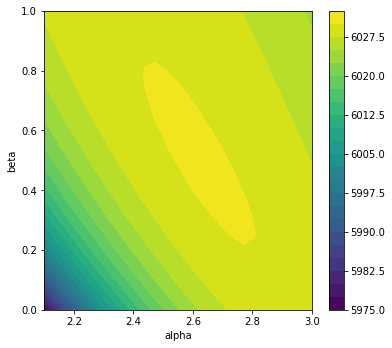

In [16]:

N = 25
betas = np.linspace(0, 1, N)
alphas = np.linspace(2.1, 3.0, N)
a, b = np.meshgrid(alphas, betas)

zs = []
for alpha, beta in tqdm(zip(a.ravel(), b.ravel())):
    p, _ = model_probability([4, alpha, beta], [observation], fit_range=fit_range)
    zs.append(p)

zs = np.array(zs)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5.5))
cf = ax1.contourf(a, b, zs.reshape(len(a), -1),  levels=24,)
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
plt.colorbar(cf, ax=ax1)

# plt.scatter(alphas[m_a], betas[m_b])

625it [00:01, 325.79it/s]


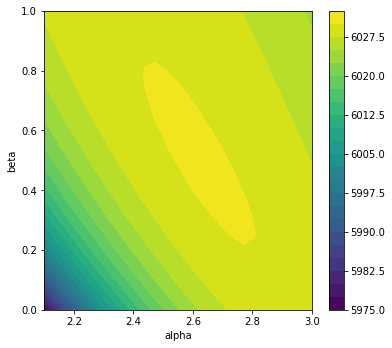

In [17]:
N = 25
betas = np.linspace(0, 1, N)
alphas = np.linspace(2.1, 3.0, N)
a, b = np.meshgrid(alphas, betas)

zs = []
for alpha, beta in tqdm(zip(a.ravel(), b.ravel())):
    p, _ = wstat_model(4, alpha, beta, observation, fit_range=fit_range)
    zs.append(p)

zs = np.array(zs)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5.5))
cf = ax1.contourf(a, b, zs.reshape(len(a), -1),  levels=24)
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
plt.colorbar(cf, ax=ax1)

625it [00:13, 45.50it/s]


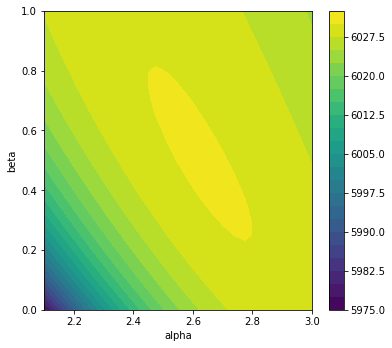

In [18]:
N = 25
betas = np.linspace(0, 1, N)
alphas = np.linspace(2.1, 3.0, N)



amplitude = T.dscalar('amplitude')
alpha = T.dscalar('alpha')
beta = T.dscalar('beta')
cf = forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observation)

zs = []
a, b = np.meshgrid(alphas, betas)
for al, be in tqdm(zip(a.ravel(), b.ravel())):
    mu_sig = cf.eval({amplitude: 4.0, alpha: al, beta: be})
    
    p, _ = wstat_model_symbolic(mu_sig, observation, fit_range=fit_range)
    zs.append(p)

zs = np.array(zs)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5.5))
cf = ax1.contourf(a, b, zs.reshape(len(a), -1),  levels=24)
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
plt.colorbar(cf, ax=ax1)

In [19]:
def get_observed_counts(observations, fit_range=None):
    on_data = []
    off_data = []
    
    for observation in observations:
        on_data.append(observation.on_vector.data.data.value)
        off_data.append(observation.off_vector.data.data.value)
    
    on_data = np.sum(on_data, axis=0)
    off_data = np.sum(off_data, axis=0)
    if fit_range:
        on_data, off_data = apply_range(on_data, off_data, fit_range=fit_range, bins=energy_bins)
    
    return on_data, off_data

In [21]:
on_data, off_data = get_observed_counts(obs_list, fit_range=fit_range)
on_data, off_data

(array([ 0.,  0.,  0., 18., 64., 77., 81., 75., 72., 51., 50., 32., 39.,
        27., 22., 11., 10., 11., 11.,  8.,  5.,  5.,  8.,  5.,  3.,  2.,
         2.,  0.,  0.,  2.,  0.,  0.,  0.,  0.]),
 array([  0.,   0.,   0.,  73., 296., 290., 353., 258., 231., 194., 153.,
        134., 100.,  64.,  63.,  63.,  39.,  33.,  22.,  19.,  15.,  10.,
         13.,   5.,   7.,   7.,   5.,   4.,   1.,   1.,   2.,   0.,   0.,
          0.]))

In [28]:
on_data = observation.on_vector.data.data.value
off_data = observation.off_vector.data.data.value
    
on_data, off_data, obs_alpha = apply_range(on_data, off_data, observation.alpha, fit_range=fit_range, bins=energy_bins)

exposure_ratio = observation.alpha[0]   # 1/9 = 0.11111

model = pm.Model(theano_config={'compute_test_value': 'ignore'})
with model:

    amplitude = pm.TruncatedNormal('amplitude', mu=4, sd=2, lower=0, testval=4)
    alpha = pm.TruncatedNormal('alpha', mu=2.5, sd=1, lower=0, testval=2.5)
    beta = pm.TruncatedNormal('beta', mu=0.5, sd=0.5, lower=0, testval=0.5)
    
#     amplitude = pm.HalfFlat('amplitude',testval=4)
#     alpha = pm.HalfFlat('alpha', testval=2.5)
#     beta = pm.HalfFlat('beta', testval=0.5)
    
    mu_s = forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observation, fit_range=fit_range,)

    mu_b = pm.HalfFlat('mu_b', shape=len(off_data))
#     log_mu_b = pm.Normal('log_mu_b', mu=4, sd=4, shape=len(off_data))
    
#     mu_b = pm.math.exp(log_mu_b)
    
    b = pm.Poisson('background', mu=mu_b, observed=off_data)    
    s = pm.Poisson('signal', mu=mu_s + exposure_ratio * mu_b, observed=on_data)

In [29]:
model.test_point

{'amplitude_lowerbound__': array(1.3862944, dtype=float32),
 'alpha_lowerbound__': array(0.91629076, dtype=float32),
 'beta_lowerbound__': array(-0.6931472, dtype=float32),
 'mu_b_log__': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32)}

625it [00:21, 32.11it/s]


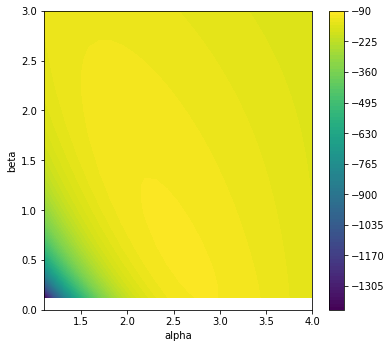

In [30]:
N = 25
betas = np.linspace(0, 3, N)
alphas = np.linspace(1.1, 4.0, N)
f = model.logp
zs = []
a, b = np.meshgrid(alphas, betas)
for al, be in tqdm(zip(a.ravel(), b.ravel())):
        
    p = f(amplitude_lowerbound__ = np.log(4), alpha_lowerbound__ = np.log(al), beta_lowerbound__= np.log(be), mu_b_log__ = np.log(off_data + 0.01))
    zs.append(p)

zs = np.array(zs)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5.5))
cf = ax1.contourf(a, b, zs.reshape(len(a), -1),  levels=124)
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
plt.colorbar(cf, ax=ax1)

In [31]:
map_estimate = pm.find_MAP(model=model)
map_estimate

logp = -168.05, ||grad|| = 0.1409: 100%|██████████| 250/250 [00:42<00:00,  5.91it/s]   


{'amplitude_lowerbound__': array(1.2481782, dtype=float32),
 'alpha_lowerbound__': array(0.93062264, dtype=float32),
 'beta_lowerbound__': array(-0.8030609, dtype=float32),
 'mu_b_log__': array([-7.5353494 , -7.5353494 , -7.5353494 ,  4.2722316 ,  5.712683  ,
         5.703647  ,  5.88353   ,  5.5746193 ,  5.462995  ,  5.260745  ,
         5.0349793 ,  4.8713117 ,  4.618776  ,  4.159055  ,  4.1370835 ,
         4.0948744 ,  3.6277146 ,  3.4847722 ,  3.1087072 ,  2.9500318 ,
         2.6897585 ,  2.3143773 ,  2.6679132 ,  1.7107205 ,  1.974515  ,
         1.9472001 ,  1.6472143 ,  1.2808905 , -0.10076813,  0.37941355,
         0.6102189 , -7.5353494 , -7.5353494 , -7.5353494 ], dtype=float32),
 'amplitude': array(3.4839902, dtype=float32),
 'alpha': array(2.5360878, dtype=float32),
 'beta': array(0.44795573, dtype=float32),
 'mu_b': array([5.33874729e-04, 5.33874729e-04, 5.33874729e-04, 7.16814194e+01,
        3.02682129e+02, 2.99959412e+02, 3.59074585e+02, 2.63649170e+02,
        2.358

In [258]:
map_estimate = pm.find_MAP(model=model)
map_estimate

logp = -164.51, ||grad|| = 0.29834: 100%|██████████| 175/175 [00:29<00:00,  5.92it/s] 


{'amplitude_lowerbound__': array(1.3450185, dtype=float32),
 'alpha_lowerbound__': array(0.94221854, dtype=float32),
 'beta_lowerbound__': array(-0.6573179, dtype=float32),
 'mu_b_log__': array([-6.4025273 , -6.4025273 , -6.4025273 ,  4.2664557 ,  5.7078915 ,
         5.697599  ,  5.8783646 ,  5.5684023 ,  5.456788  ,  5.2554955 ,
         5.029358  ,  4.867582  ,  4.613612  ,  4.154564  ,  4.1338816 ,
         4.0936646 ,  3.6241815 ,  3.4835184 ,  3.1079512 ,  2.952046  ,
         2.691261  ,  2.321428  ,  2.67318   ,  1.7229766 ,  1.9873177 ,
         1.9566704 ,  1.6606425 ,  1.2720245 , -0.10094213,  0.48456162,
         0.5609364 , -6.4025273 , -6.4025273 , -6.4025273 ], dtype=float32),
 'amplitude': array(3.8382576, dtype=float32),
 'alpha': array(2.5656672, dtype=float32),
 'beta': array(0.51823944, dtype=float32),
 'mu_b': array([1.6573633e-03, 1.6573633e-03, 1.6573633e-03, 7.1268585e+01,
        3.0123523e+02, 2.9815067e+02, 3.5722455e+02, 2.6201514e+02,
        2.3434352e+02

In [61]:
with model:
#     step1 = pm.Metropolis([mu_b])
#     step2 = pm.NUTS([amplitude, alpha, beta], target_accept=0.9)
#     trace = pm.sample(1000, step=[step1, step2], chains=5, cores=5)
    trace = pm.sample(100, chains=5, cores=5, init='auto', target_accept=0.8)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [log_mu_b, beta, alpha, amplitude]
Sampling 5 chains: 100%|██████████| 3000/3000 [45:28<00:00,  1.02draws/s] 


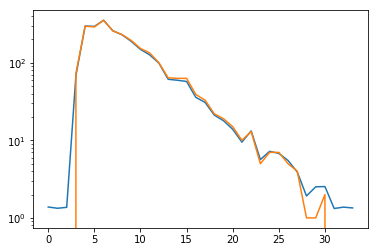

In [64]:
# plt.plot(map_estimate['mu_b'])
plt.plot(np.median(np.exp(trace['log_mu_b']), axis=0))
# plt.plot(trace['mu_b'].mean(axis=0))
plt.plot(off_data)
plt.yscale('log')

/home/kbruegge/envs/gammapy/lib/python3.7/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf3fea2eb8>,
      dtype=object)

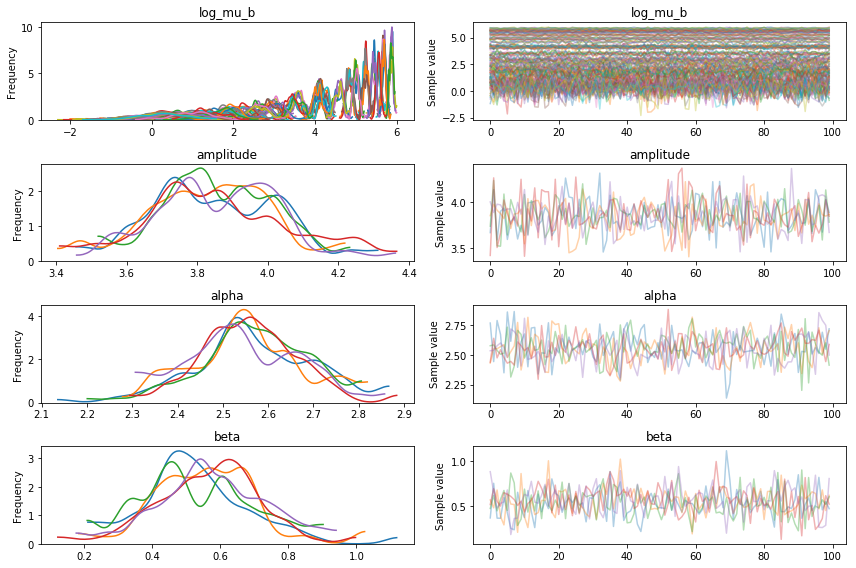

In [65]:
pm.traceplot(trace)

In [75]:
with model:
    samples = pm.sample_ppc(trace)

100%|██████████| 100/100 [00:08<00:00, 11.54it/s]


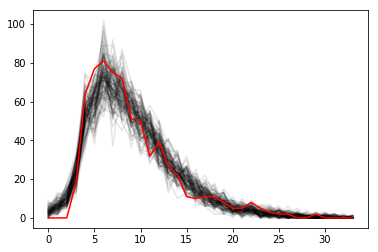

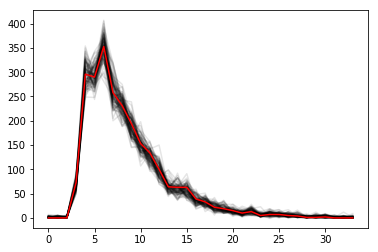

In [88]:
plt.figure()
plt.plot(samples['signal'].T, color='k', alpha=0.1)
plt.plot(on_data, color='red')

plt.figure()
plt.plot(samples['background'].T, color='k', alpha=0.1)
plt.plot(off_data, color='red')

None

In [94]:
pm.summary(trace).round(3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
log_mu_b__0,0.266,0.611,0.022,-0.907,1.385,785.403,1.000
log_mu_b__1,0.252,0.651,0.024,-1.128,1.431,890.927,0.998
log_mu_b__2,0.266,0.621,0.024,-0.895,1.428,817.294,1.001
log_mu_b__3,4.228,0.117,0.004,4.017,4.454,1208.617,0.998
log_mu_b__4,5.695,0.053,0.002,5.593,5.800,1151.206,0.999
log_mu_b__5,5.683,0.056,0.002,5.577,5.802,1904.593,0.996
log_mu_b__6,5.867,0.050,0.002,5.771,5.963,724.297,1.000
log_mu_b__7,5.556,0.064,0.002,5.435,5.686,1394.629,0.997
log_mu_b__8,5.437,0.066,0.002,5.301,5.566,1595.474,0.996
log_mu_b__9,5.239,0.071,0.002,5.110,5.396,1070.531,0.998


In [95]:
trace['amplitude'].mean(), trace['alpha'].mean(), trace['beta'].mean()

(3.8503866, 2.5567994, 0.54980445)

In [96]:
np.median(trace['amplitude']), np.median(trace['alpha']), np.median(trace['beta'])

(3.8444183, 2.5514915, 0.54464173)

In [97]:
# display the total number and percentage of divergent
divergent = trace['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size / len(trace) * 100
print('Percentage of Divergent %.1f' % divperc)

Number of Divergent 0
Percentage of Divergent 0.0


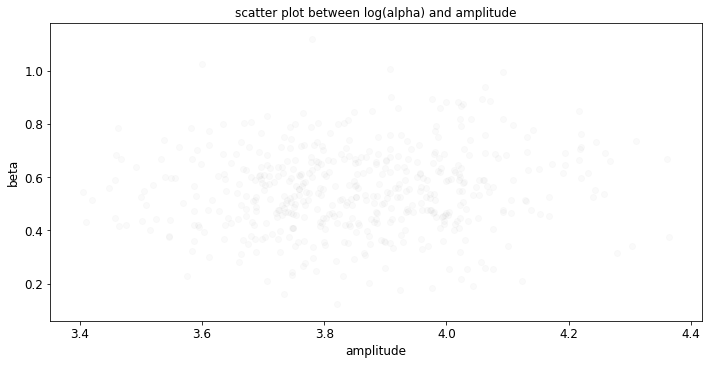

In [98]:
pm.pairplot(trace,
           sub_varnames=['amplitude', 'beta'],
           divergences=True,
           color='k', alpha=0.02, figsize=(10, 5), kwargs_divergence={'color':'C2'})
plt.title('scatter plot between log(alpha) and amplitude');

In [112]:
from collections import defaultdict
divergent_point = defaultdict(list)

chain_warn = trace.report._chain_warnings
for i in range(len(chain_warn)):
    for warning_ in chain_warn[i]:
        if warning_.step is not None and warning_.extra is not None:
            for RV in model.free_RVs:
                para_name = RV.name
                divergent_point[para_name].append(warning_.extra[para_name])

for RV in model.free_RVs:
    para_name = RV.name
    divergent_point[para_name] = np.asarray(divergent_point[para_name])

ii = 5
amplitude_log_d = divergent_point['amplitude_log__']
# print(divergent_point)
mu_5_d = divergent_point['log_mu_b'][:, ii]
Ndiv_recorded = len(divergent_point['log_mu_b'])
mu_5_d

IndexError: too many indices for array

KeyError: 'mu_b_log___5'

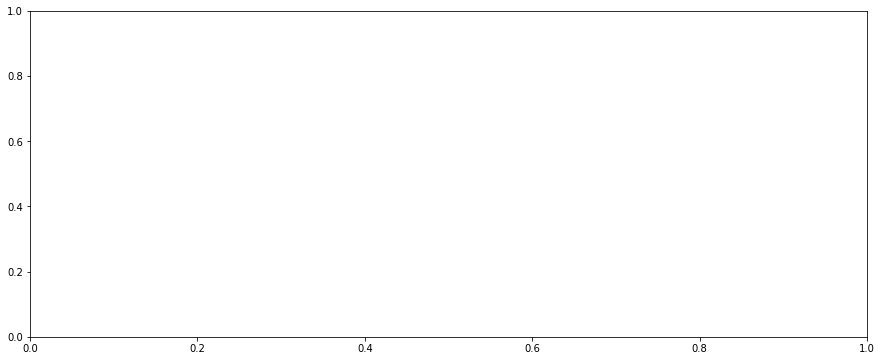

In [104]:
param = 'alpha_log__'
parameter_log_divergence = divergent_point[param]

_, ax = plt.subplots(1, 1, figsize=(15, 6))
pm.pairplot(trace,
               sub_varnames=['mu_b_log___5', param],
               divergences=True,
               ax=ax,
               color='C7', alpha=0.2, figsize=(12, 10),
               kwargs_divergence={'color':'C2', 'label':'Divergent samples'})

mu_trace = trace['mu_b_log__']
mu_0 = mu_trace[:, 5]

plt.plot([mu_0[divergent == 1][:Ndiv_recorded], mu_0_d], 
         [trace[param][divergent == 1][:Ndiv_recorded], parameter_log_divergence], 'k-', alpha=.25)

plt.scatter(mu_0_d, parameter_log_divergence,
              color='C3', alpha=.9, label='Location of Energy error (start location of leapfrog)')
# ax.scatter(divsp.T, 'C3', lw=.5)
# plt.title('scatter plot between log(tau) and theta[0]')
plt.legend()


In [113]:
tracedf = pm.trace_to_dataframe(trace)
plotorder = ['amplitude', 'alpha', 'beta'] + [f'mu_b__{i}' for i in range(len(off_data))]
tracedf = tracedf[plotorder]

_, ax = plt.subplots(1, 1, figsize=(12, 5))
# ax.plot(tracedf.values[divergent == 0].T, color='k', alpha=.025)
# ax[0].plot(tracedf.values[divergent == 1].T, color='C2', lw=.5)

ax.plot(tracedf.values[divergent == 0].T, color='k', alpha=.01)
ax.plot(tracedf.values[divergent == 1].T, color='C2', lw=2)
divsp = np.hstack([divergent_point['amplitude_log__'][:,None],
                   divergent_point['alpha_log__'][:,None],
                   divergent_point['beta_log__'][:,None],
                   divergent_point['mu_b_log__']
                  ])
ax.plot(divsp.T, 'C3', lw=.5)

plt.xticks(range(len(off_data)), plotorder)
plt.tight_layout()


KeyError: "['mu_b__0' 'mu_b__1' 'mu_b__2' 'mu_b__3' 'mu_b__4' 'mu_b__5' 'mu_b__6'\n 'mu_b__7' 'mu_b__8' 'mu_b__9' 'mu_b__10' 'mu_b__11' 'mu_b__12' 'mu_b__13'\n 'mu_b__14' 'mu_b__15' 'mu_b__16' 'mu_b__17' 'mu_b__18' 'mu_b__19'\n 'mu_b__20' 'mu_b__21' 'mu_b__22' 'mu_b__23' 'mu_b__24' 'mu_b__25'\n 'mu_b__26' 'mu_b__27' 'mu_b__28' 'mu_b__29' 'mu_b__30' 'mu_b__31'\n 'mu_b__32' 'mu_b__33'] not in index"